# Setup & Imports

In [1]:
import os
import gzip
import shutil
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


In [2]:
from pathlib import Path
import os, gzip, shutil

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

data_gz_path = DATA_DIR / "traffic.pcapng.gz"
data_pcapng_path = DATA_DIR / "traffic.pcapng"

if not data_gz_path.exists() and not data_pcapng_path.exists():
    raise FileNotFoundError(
        "Dataset not found.\n"
        "Please place 'traffic.pcapng.gz' (or the decompressed 'traffic.pcapng') "
        "inside the './data' folder before running this notebook."
    )

if data_gz_path.exists() and not data_pcapng_path.exists():
    print("Decompressing traffic.pcapng.gz...")
    with gzip.open(data_gz_path, "rb") as f_in, open(data_pcapng_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print("Decompression complete.")

data_pcapng_path = str(data_pcapng_path)
print("Using dataset:", data_pcapng_path)

Decompressing traffic.pcapng.gz...
Decompression complete.
Using dataset: data/traffic.pcapng


In [3]:
!apt-get -y install libpcap-dev

!pip install pcapml-fe scikit-learn pandas numpy matplotlib tqdm


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdbus-1-dev libpcap0.8 libpcap0.8-dev
The following NEW packages will be installed:
  libdbus-1-dev libpcap-dev libpcap0.8 libpcap0.8-dev
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 607 kB of archives.
After this operation, 2,238 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap0.8 amd64 1.10.1-4ubuntu1.22.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdbus-1-dev amd64 1.12.20-2ubuntu4.1 [188 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap0.8-dev amd64 1.10.1-4ubuntu1.22.04.1 [270 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcap-dev amd64 1.10.1-4ubuntu1.22.04.1 [3,326 B]
Fetched 607 kB in 1s (828 kB/s)
Selecting previously unselected package libpcap0.8

# Exploring the Raw netML Samples


In [4]:
import pcapml_fe
import itertools

for sample in itertools.islice(pcapml_fe.sampler(data_pcapng_path), 5):
    print("sid:", sample.sid)
    print("metadata:", repr(sample.metadata))
    print("num packets:", len(sample.packets))
    print("-" * 40)


sid: 4740404938944317776
metadata: 'malware_pua'
num packets: 4
----------------------------------------
sid: 8131368769381413716
metadata: 'malware_pua'
num packets: 4
----------------------------------------
sid: 5014021244806424827
metadata: 'malware_pua'
num packets: 2
----------------------------------------
sid: 6692355505842633157
metadata: 'malware_pua'
num packets: 4
----------------------------------------
sid: 8708165883206174450
metadata: 'malware_pua'
num packets: 2
----------------------------------------


# Feature Extraction from Each Flow


In [5]:
def featurize_sample(sample):
    """
    Build simple flow features and a binary label:
    - label = 1 if metadata contains 'malware'
    - label = 0 otherwise
    Features:
      [num_pkts, total_bytes, mean_size, std_size, duration, mean_iat]
    """
    # --- parse metadata into a binary label ---
    meta = sample.metadata
    if isinstance(meta, bytes):
        meta = meta.decode("utf-8", errors="ignore")
    meta = str(meta).strip().lower()

    if not meta:
        return None, None

    # binary label: malware vs non-malware
    easy_label = 1 if "malware" in meta else 0

    # --- packet-based features ---
    pkts = getattr(sample, "packets", None)
    if not pkts:
        return None, None

    sizes = np.array([len(p.raw_bytes) for p in pkts], dtype=float)
    times = np.array([p.ts for p in pkts], dtype=float)

    num_pkts    = float(len(pkts))
    total_bytes = float(sizes.sum())
    mean_size   = float(sizes.mean())
    std_size    = float(sizes.std())

    if len(times) > 1:
        duration = float(times.max() - times.min())
        inter_arrivals = np.diff(np.sort(times))
        mean_iat = float(inter_arrivals.mean())
    else:
        duration = 0.0
        mean_iat = 0.0

    feats = [
        num_pkts,
        total_bytes,
        mean_size,
        std_size,
        duration,
        mean_iat,
    ]
    return feats, easy_label


# Building the Dataset (X, y)


In [6]:
X = []
y = []

for sample in tqdm(pcapml_fe.sampler(data_pcapng_path), desc="Reading samples"):
    feats, label = featurize_sample(sample)
    if feats is None:
        continue
    X.append(feats)
    y.append(label)

X = np.array(X, dtype=float)
y = np.array(y, dtype=int)

X.shape, y.shape


Reading samples: 498446it [02:24, 3444.90it/s]


((498446, 6), (498446,))

In [7]:
unique, counts = np.unique(y, return_counts=True)
label_counts = dict(zip(unique, counts))
label_counts


{np.int64(0): np.int64(129121), np.int64(1): np.int64(369325)}

# Label Distribution


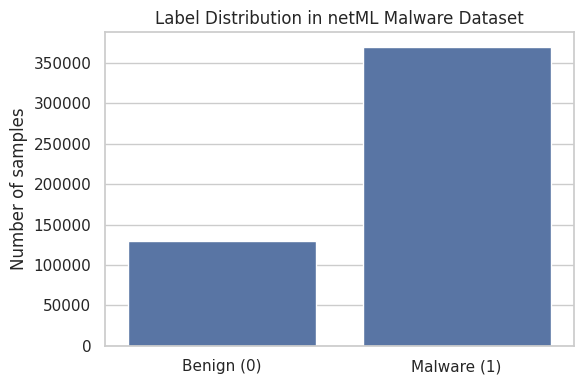

In [8]:
# Label distribution plot
labels, counts = zip(*sorted(label_counts.items()))
labels = [int(l) for l in labels]

plt.figure()
sns.barplot(x=labels, y=counts)
plt.xticks([0, 1], ["Benign (0)", "Malware (1)"])
plt.ylabel("Number of samples")
plt.title("Label Distribution in netML Malware Dataset")
plt.tight_layout()
plt.savefig("label_distribution.png", dpi=200)
plt.show()


# Train/Test Split & Preprocessing


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape


((398756, 6), (99690, 6))

In [10]:
def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    """
    Fit model, compute balanced accuracy, and print classification report + CM.
    Returns (balanced_accuracy, y_pred).
    """
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    bal_acc = balanced_accuracy_score(y_te, y_pred)
    print(f"{name} – Balanced accuracy: {bal_acc:.4f}")
    print(classification_report(y_te, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("-" * 60)
    return bal_acc, y_pred


def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=200)
    plt.show()


# Training Multiple Models


In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)

bal_acc_lr, y_pred_lr = evaluate_model(
    "Logistic Regression",
    log_reg,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
)


Logistic Regression – Balanced accuracy: 0.5765
              precision    recall  f1-score   support

           0       0.35      0.42      0.39     25824
           1       0.78      0.73      0.76     73866

    accuracy                           0.65     99690
   macro avg       0.57      0.58      0.57     99690
weighted avg       0.67      0.65      0.66     99690

Confusion matrix:
 [[10964 14860]
 [20056 53810]]
------------------------------------------------------------


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42,
)

bal_acc_rf, y_pred_rf = evaluate_model(
    "Random Forest",
    rf,
    X_train,
    X_test,
    y_train,
    y_test,
)


Random Forest – Balanced accuracy: 0.9927
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25824
           1       1.00      1.00      1.00     73866

    accuracy                           0.99     99690
   macro avg       0.99      0.99      0.99     99690
weighted avg       0.99      0.99      0.99     99690

Confusion matrix:
 [[25563   261]
 [  337 73529]]
------------------------------------------------------------


# Feature Importance (Random Forest)


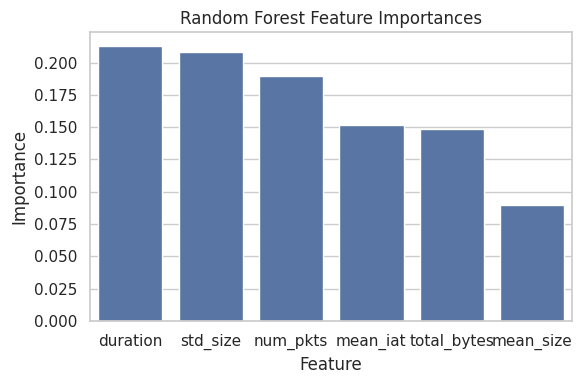

In [13]:
feature_names = [
    "num_pkts",
    "total_bytes",
    "mean_size",
    "std_size",
    "duration",
    "mean_iat",
]

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
sns.barplot(
    x=[feature_names[i] for i in indices],
    y=importances[indices],
)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.savefig("rf_feature_importances.png", dpi=200)
plt.show()


In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.1,
    random_state=42,
)

bal_acc_hgb, y_pred_hgb = evaluate_model(
    "HistGradientBoosting",
    hgb,
    X_train,
    X_test,
    y_train,
    y_test,
)


HistGradientBoosting – Balanced accuracy: 0.9877
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     25824
           1       0.99      0.99      0.99     73866

    accuracy                           0.99     99690
   macro avg       0.99      0.99      0.99     99690
weighted avg       0.99      0.99      0.99     99690

Confusion matrix:
 [[25375   449]
 [  530 73336]]
------------------------------------------------------------


# Model Comparison


Best model: RandomForest with balanced accuracy 0.9927


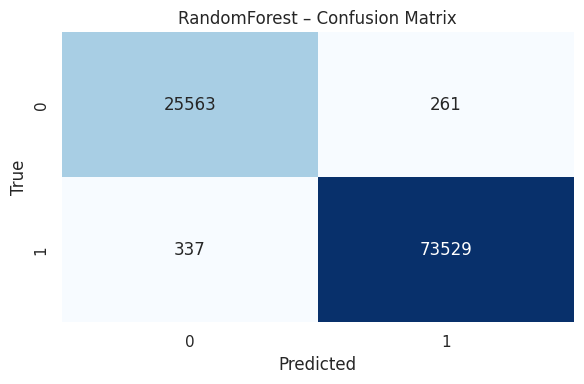

In [15]:
scores = {
    "LogReg": (bal_acc_lr, y_pred_lr),
    "RandomForest": (bal_acc_rf, y_pred_rf),
    "HistGB": (bal_acc_hgb, y_pred_hgb),
}

best_name = max(scores, key=lambda k: scores[k][0])
best_score, best_preds = scores[best_name]

print(f"Best model: {best_name} with balanced accuracy {best_score:.4f}")
plot_confusion_matrix(y_test, best_preds, f"{best_name} – Confusion Matrix")


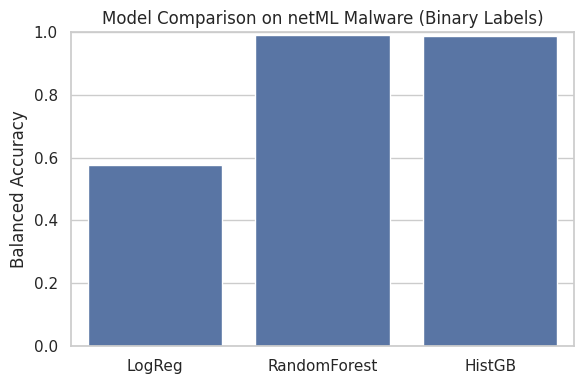

In [16]:
model_names = list(scores.keys())
bal_scores = [scores[m][0] for m in model_names]

plt.figure()
sns.barplot(x=model_names, y=bal_scores)
plt.ylim(0.0, 1.0)
plt.ylabel("Balanced Accuracy")
plt.title("Model Comparison on netML Malware (Binary Labels)")
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=200)
plt.show()


# Confusion Matrix of the Best Model


# ROC Curve for the Best Model


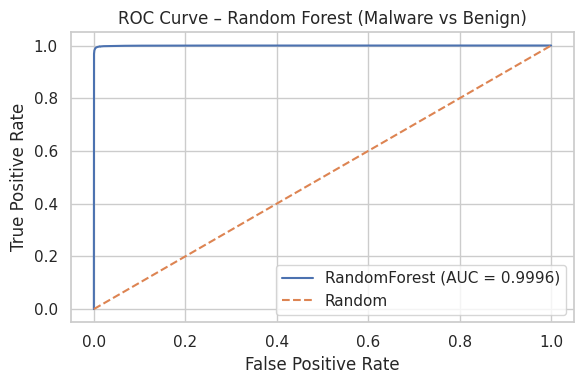

In [17]:
# ROC curve for Random Forest
# Make sure rf is already fitted (it is, from evaluate_model)

y_proba_rf = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (malware)

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr, tpr, label=f"RandomForest (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest (Malware vs Benign)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=200)
plt.show()


In [18]:
!pip install sphinx

In [19]:
!mkdir -p docs
!sphinx-quickstart docs --quiet --project "ML for Computer Systems Project" --author "Your Name" --sep



Finished: An initial directory structure has been created.

You should now populate your master file /content/docs/source/index.rst and create other documentation
source files. Use the Makefile to build the docs, like so:
   make builder
where "builder" is one of the supported builders, e.g. html, latex or linkcheck.

